In [9]:
# General use imports
import PIL
import math
import glob
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#  Dataset loading libraries
from google.colab import drive
from tensorflow.keras.utils import image_dataset_from_directory

# Image processing libraries
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from sklearn.preprocessing import label_binarize

# Tensorflow libraries for neural network layers
!pip install -q -U keras-tuner
import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Transfer learning model
from keras.applications.inception_v3 import InceptionV3

# Classification Performance metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Jupyter Notebook settings
import warnings
from IPython.display import Image
warnings.filterwarnings('ignore')
from IPython.display import display, HTML, Markdown, Image
plt.rcParams['figure.figsize'] = [24, 8]
sns.set_theme(style="darkgrid")

In [10]:
################################################################################
#  Dataset manager: Initialize paths and load the dataset from google drive
################################################################################
class Dataset():

    PATH = '/content/gdrive/MyDrive/CSPB_4830_deep_learning_project/'

    def __init__(self):
        '''
        Initialize the dataset filesystem paths from google drive.
        '''
        drive.mount('/content/gdrive', force_remount=True)
        self.train = pathlib.Path(self.PATH + 'dataset/seg_train')
        self.test  = pathlib.Path(self.PATH + 'dataset/seg_test')
        self.pred  = pathlib.Path(self.PATH + 'dataset/seg_pred')

    def load(self, batch_size=None):
        '''
        Load the dataset into tensorflow Dataset objects using the native split.
        '''
        train = image_dataset_from_directory(self.train, 
                                             image_size=(150, 150),
                                             batch_size=batch_size)
        test  = image_dataset_from_directory(self.test, 
                                             image_size=(150, 150),
                                             batch_size=batch_size)
        return train, test

################################################################################
#  Helper Functions
################################################################################
def plot_loss(log, epochs):
    '''
    Plot training accuracy and validation accuracy from a keras history object.
    '''
    # Collect accuracy and loss data from the keras training log
    training_accuracy = log.history['accuracy']
    val_accuracy = log.history['val_accuracy']
    training_loss = log.history['loss']
    val_loss = log.history['val_loss']
    epochs = range(epochs)

    # Set plot titles and group logs for plotting
    titles = ["Training Accuracy vs Validation Accuracy", 
              "Training Loss vs Validation Loss"]
    logs = [(training_accuracy, val_accuracy), 
            (training_loss, val_loss)]

    # Create plots for accuracy and loss during training
    fig, axes = plt.subplots(nrows=1, ncols=2)
    for log, t, ax in zip(logs, titles, axes.flat):
        ax.plot(epochs, log[0], label="Training", marker='o')
        ax.plot(epochs, log[1], label="Validation", marker='o')
        ax.set_title(t, fontsize=20); ax.set_xlabel("Epoch")
        ax.legend(loc='upper left')

def predict_label(path, model, model_name, n):
    '''
    Given a model and image path, display n images and predict their labels.
    '''
    # Get all images from path and generate set of random image indices
    images, predictions, softmax = [], [], []
    image_paths = glob.glob(str(path) + "/*.jpg")
    rand_indices = np.random.randint(low=0, high=len(image_paths), size=n)

    # Load randomly selected images from path using the random indices
    for i in rand_indices:
        img = load_img(image_paths[i], target_size=(150,150))
        img_arr = img_to_array(img)
        img_arr = tf.expand_dims(img_arr, 0)
        pred = model.predict(img_arr)
        score = tf.nn.softmax(pred[0])
        predicted_label = class_labels[np.argmax(score)]

        # Collect images, predicted labels, and softmax scores
        images.append(img)
        predictions.append(predicted_label)
        softmax.append(score)

    # Plot the randomly sampled images and their predictions
    fig, axes = plt.subplots(nrows=math.ceil(n/5), ncols=5)
    for img, label, s, ax in zip(images, predictions, softmax, axes.flat):
        max_softmax = np.round(np.max(s) * 100, 2)
        ax.imshow(img); ax.set_axis_off()
        ax.set_title(f"{label}\nsoftmax={max_softmax}%")
    fig.suptitle(f"{model_name} Predictions\n", fontsize=20)

def compute_confusion_matrix(model, x_test, labels):
    '''
    Compute a confusion matrix given a model, test data, and test data labels.
    Returns the confusion matrix and labels corresponding to y_pred, y_true
    '''
    # Get predictions from the test set
    pred = model.predict(test, verbose=2)
    y_pred = np.argmax(pred, axis=1)

    # Collect labels from training set batches
    y_true = np.concatenate([labels for images, labels in test], axis=0)

    # Create confusion matrix
    cm = tf.math.confusion_matrix(
        labels=y_true,
        predictions = y_pred,
        num_classes=len(labels)
    )
    return cm, ([labels[i] for i in y_pred], [labels[i] for i in y_true])

def plot_multiclass_ROC(y_pred, y_true, model, class_labels, plot_label, axis):
    '''
    Plot ROC curves for each class from a multiclass classification model.
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    '''
    # Convert multi-class test labels to one-vs-all binary
    y_true = label_binarize(y_true, classes=class_labels)

    # Collect false positive and true positive rates and compute AUC
    fpr, tpr, roc_auc = dict(), dict(), dict()
    n_classes = y_true.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    for i, c in zip(range(n_classes), class_labels):
        axis.plot(fpr[i], tpr[i], lw=2, label=f"{c} (AUC = {roc_auc[i]:.2f})")

    # Set plot limits and labels
    axis.plot([0, 1], [0, 1], 'k--', lw=2)
    axis.set_xlim([-0.05, 1.0]); axis.set_ylim([0.0, 1.05])
    axis.set_xlabel('False Positive Rate')
    axis.set_ylabel('True Positive Rate')
    axis.set_title(label=f"{plot_label}", 
                   fontdict={'fontsize':18}) 
    axis.legend(loc="lower right")

<figure>
  <IMG SRC="https://www.colorado.edu/cs/profiles/express/themes/cuspirit/logo.png" WIDTH=50 ALIGN="right">
</figure>

## Image Classification with Convolutional Neural Networks
*CSPB 4830 Machine Learning - Summer 2022*

* Author: Thomas Cochran

* Github: https://github.com/t-cochran/CSPB_4830_Deep_Learning_Project

__Project Description__

* The goal of this project is to build and train convolutional neural networks that can classify scenic images. 

__Problem Type__

* This is a supervised multi-class classification problem. We will be training our models using labeled images corresponding to scenic locations, e.g. streets, buildings, mountains, oceans, or forests. 

__Project Motivation__

* The primary motivator of this project is to learn more about building, training, and optimizing convolutional neural networks for image classification. This is useful for processing an ever increasing amount of image data generated by social media, smartphones, and IoT.

---

## Dataset Information

__Dataset source__

* This dataset is available from the following kaggle competition [[source](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)]. 

* The primary source is a machine learning classification challenge hosted by Intel [[source](https://datahack.analyticsvidhya.com/contest/practice-problem-intel-scene-classification-challe/)]. 

__Dataset size and features__

* The dataset consists entirely of color images with dimensions 150px by 150px in `.jpg` format.

* Images are grouped into three sets for training, testing, and predicting. Here is a summary of the dataset's contents:

    * `seg_train/`: 203 MB size, 14034 total labeled images for model training.
    * `seg_test/`:  43.2 MB size, 3000 total labeled images for model testing.
    * `seg_pred/`:  76.4 MB size, 5305 total un-labeled images for predicting. 

* Folders `seg_train/` and `seg_test/` have 6 sub-directories containing images corresponding to the 6 class labels in the dataset:

    * `buildings/`, `forest/`, `glacier/`, `mountain/`, `sea/`, `street/`

* Each of these folders contain approximately 2000 to 2500 images for the training set, and 400 to 500 images for the test set. 

__Loading the dataset__

* I will access the dataset from my google drive using a simple API that I wrote via the `Dataset()` object.

* The dataset will use the native train-test split, and I will load these sets into tensorflow `tf.data.Dataset` objects:

In [3]:
# Instantiate dataset manager which loads 
dataset = Dataset()

# Load the native train/test split as a tf.data.Dataset object
BATCH_SIZE = 64
train, test = dataset.load(batch_size=BATCH_SIZE)

# Get class labels from the training set
class_labels = train.class_names

Mounted at /content/gdrive
Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


---

## Data cleaning and pre-processing:

__Create pre-processing layers__

* The `augmentation_layer` is a pre-processing layer that applies several random transformations to the training images during each training epoch. The intent of this process is to decrease overfitting by providing the model with the same training images taken from multiple unique vantage points. These different vantage points can improve the model's ability to make more generalizable predictions.


* The `standardization_layer` is a pre-processing layer that standardizes the image input to the model which can improve training runtime and decrease the likelihood that we will find local minima in our loss function. Since the images are centered and of the same size, we will decrease the range of the weights by standardizing the RGB channels from range `[0, 255]` to `[0, 1]` prior to training.

In [4]:
# Create data augmentation layers
augmentation_layer = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(150, 150, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.01)
])

# Create standardization layers
standardization_layer = keras.Sequential([
    layers.Rescaling(scale=1./255, input_shape=(150, 150, 3))
])

__Configure the dataset to improve training performance__

* The `cache()` transformation caches the training and test data during the first epoch. This will improve performance by reducing the number of operations required to read the data during each training epoch, since it can quickly be accessed from memory. 

* The `prefetch()` transformation improves the runtime of training and testing steps by pre-fetching the next step in the input pipeline. This allows the model to execute a training step while concurrently reading data for the next step. 

In [5]:
# Apply cache transformation to cache datasets after the first epoch
train = train.cache().shuffle(1000)
test = test.cache()

# Apply prefetch transformation to improve runtime
# Ref: https://www.tensorflow.org/guide/data_performance
train = train.prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.prefetch(buffer_size=tf.data.AUTOTUNE)

---

## Exploratory Data Analysis (EDA):

__Check image dimensions__

* First we will check the dimensions of a batch of images in the dataset. Each batch is of size $n=64$ and it should have stacks of 150px by 150px images with 3 RGB channels. 

In [6]:
# Select images in one batch (n=100) and get the dimensions
training_batch_dims = [images.shape for images, labels in train.take(1)][0]
test_batch_dims = [images.shape for images, labels in test.take(1)][0]

# Print image dimensions from a single batch in the training and test sets
print(f"training batch dimensions: {training_batch_dims}")
print(f"test batch dimensions: {test_batch_dims}")


training batch dimensions: (64, 150, 150, 3)
test batch dimensions: (64, 150, 150, 3)


__Distribution of images__

* Next I will inspect the distribution of images in each class within the training and test set in an effort to look for class imbalances:

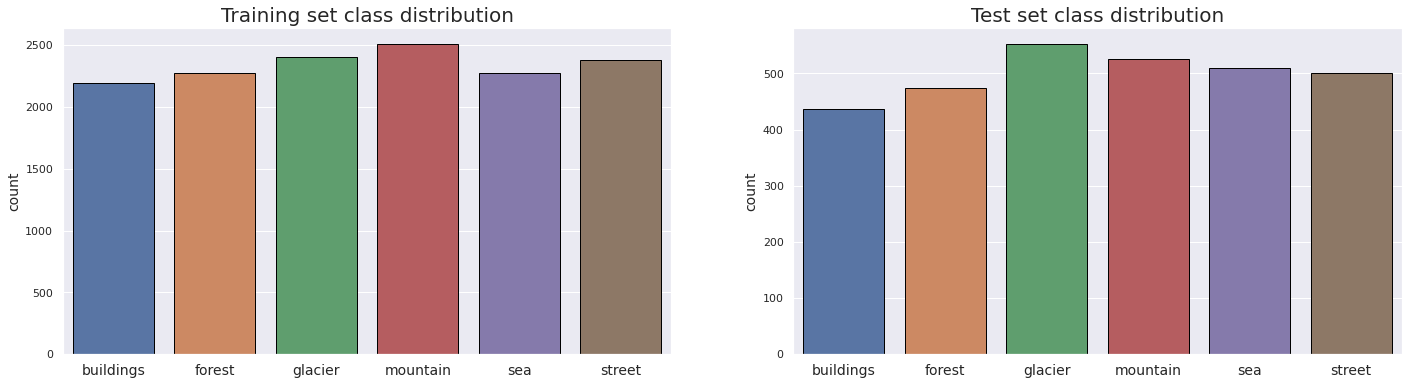

In [8]:
# Collect class labels in the train and test sets
test_labels = np.concatenate([labels for images, labels in test], axis=0)
train_labels = np.concatenate([labels for images, labels in train], axis=0)

# Plot the distribution of class labels for each set
fig, axes = plt.subplots(ncols=2, figsize=(24, 6))
for set, l, ax in zip([train_labels, test_labels], ["Training", "Test"], axes):
    sns.countplot(x=set, edgecolor='black', ax=ax)
    ax.set_title(f"{l} set class distribution", fontsize=20)
    ax.set_ylabel(ylabel="count", fontsize=14)
    ax.set_xticklabels(labels=class_labels, fontsize=14)

* The`glacier` and `mountain` classes have slightly more images than other classes, however the class distribution is fairly balanced.

__Visualize training images__

* Display a random set of training images and their assigned labels to check if the labels are consistent with the images. Recall, the target classes are `sea`, `street`, `glacier`, `buildings`, `mountain`, `forest`: 

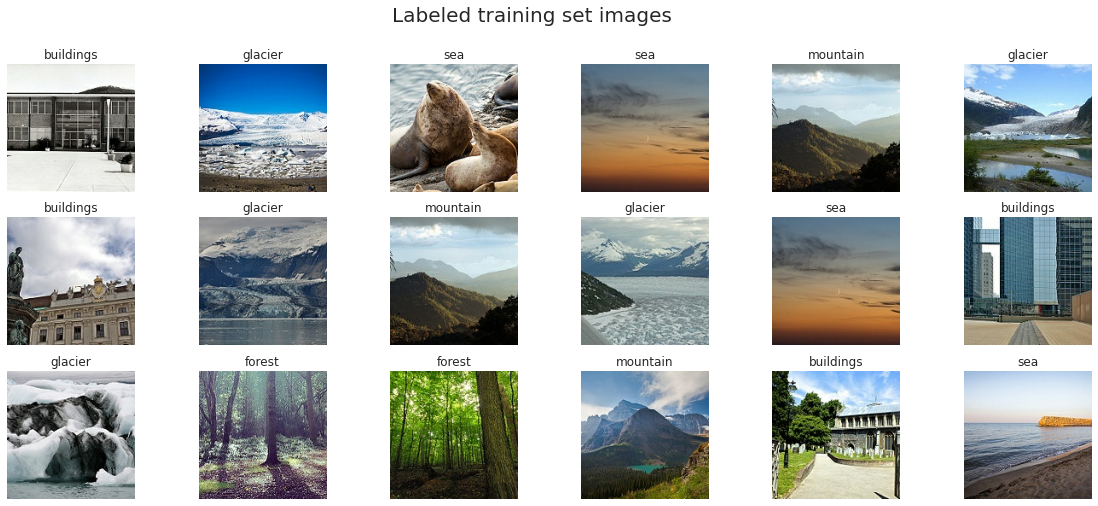

In [146]:
# Select 18 random images from the test set
img, labels = [], []
rand_indices = np.random.randint(low=0, high=BATCH_SIZE, size=18)
for images, labels in train.take(1):
    img = [images[i].numpy().astype("uint8") for i in rand_indices]
    labels = [class_labels[labels[i]] for i in rand_indices]

# Plot the random images and their assigned labels
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 8))
for i, l, ax in zip(img, labels, axes.flat):
    ax.imshow(i); ax.set_axis_off()
    ax.set_title(f"{l}")
fig.suptitle(f"Labeled training set images", fontsize=20);

* All these images look consistent with their assigned labels. One interesting observation that may be problematic for our models is `glacier` can look very similar to a `mountain`. We can see an example of this at the top right corner of the training images listed above.

__Visualize augmented images__

* Next I will check the effect of our image augmentation by passing a single image from the training set to the augmentation layer six times. 

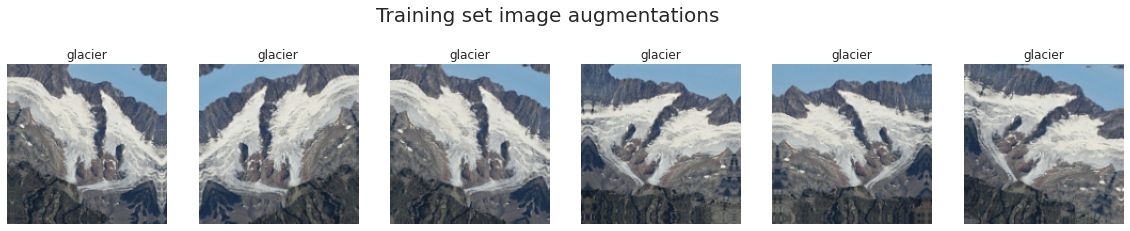

In [10]:
# Select an image from the training set and apply the transformation layer
img, label = [], []
for images, labels in train.take(1):
    for i in range(6):
        img.append(augmentation_layer(images)[0].numpy().astype("uint8"))
        label.append(class_labels[labels[0]])

# Display each image transformation
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 4))
for i, l, ax in zip(img, label, axes.flat):
    ax.imshow(i); ax.set_axis_off()
    ax.set_title(f"{l}")
fig.suptitle(f"Training set image augmentations", fontsize=20);

* The augmentation layer effectively applies several rotations and flips to each image. There should be slight differences in contrast and zoom, but these augmentations appear to be more subtle.

__EDA Summary__

* The distribution of images is not perfectly balanced in both the training set and the test set. However, it does not appear to be significantly imbalanced enough to warrant class balancing techniques.

* The labels in the training set are generally consistent with the content of the images, however there is some ambiguity, e.g. snow covered mountains look similar to some glaciers. It may be difficult to account for this ambiguity when training our models.

---

## Model Selection:

* In model selection, we will focus on training three neural networks. The first is as a relatively simple base model that subsequent models can improve upon by incorporating additional layers and optimization methods.

__Model 1: Convolutional neural network__

* The first model will be a convolutional neural network with two convolutional layers. This is a good base model becasue the achitecture is simple relative to other convolutional neural networks. 

* Despite the simplicity of the base model, the two convolutional layers are capable of extracting latent features from each input image, which should provide a substantial improvement in classification accuracy over multilayered perceptrons.


__Model 2: Deep convolutional neural network__

* The second model will be a deep convolutional neural network with hyperparameter tuning. This improves upon the base model by adding addtional convolution and pooling layers which improve the model's field of view at lower depths. 

* A larger field of view allows the model to extract more tertiary features of the input image, which should improve classification accuracy.

__Model 3: Google inceptionV3 transfer learning__

* The third model is a pre-trained deep convolutional neural network developed by Google for computer vision related tasks. The training data is from ImageNet, a large image database with crowdsourced annotations by Amazon's Mechanical Turk. 

* With over 20 million trainable parameters, this convolutional neural network goes much deeper than our second model. It should provide a significant boost to classification accuracy due in part to its large pool of training images and complex architecture. 


## Model Training:

* The architecture of each model will be constructed in sequence by stacking each layer within the `tf.keras.Sequential` object. Each layer will consist primarily of `tf.keras.layer` objects. For example, some common layers include:

    * `tf.keras.layhers.Conv2D` are convolution layers.
    * `tf.keras.layers.maxPooling2D` are pooling layers.
    * `tf.keras.layers.Dense` are fully connected layers.

__Model 1: Convolutional neural network__

* The first model is a convolutional neural network with two convolutional layers, two pooling layers, and 268,094 trainable parameters. Its archiecture is outlined in the schematic diagram below:

<img src="https://i.imgur.com/MNvvlCe.png">

In [105]:
# Model 1: convolutional neural network
convnet = Sequential([
    # Input layer: data augmentation and standardization
    augmentation_layer,
    standardization_layer,

    # Convolutional layers
    layers.Conv2D(8, (8,8), padding='same', activation='relu'),
    layers.MaxPooling2D(3,3),

    layers.Conv2D(16, (4,4), padding='same', activation='relu'),
    layers.MaxPooling2D(3,3),

    # Fully connected layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),

    # Output layer
    layers.Dense(len(class_labels), activation='softmax')
])

# Compile the base model
convnet.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# Summarize model trainable parameters
convnet.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d_204 (Conv2D)         (None, 150, 150, 8)       1544      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 50, 50, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_205 (Conv2D)         (None, 50, 50, 16)        2064      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                 

In [106]:
%%time
# Train the base model
convnet_log = convnet.fit(
    train,
    validation_data=test,
    epochs=20,
    use_multiprocessing=True
)

Epoch 1/20
220/220 [==============================] - 7s 29ms/step - loss: 1.1981 - accuracy: 0.5329 - val_loss: 1.0241 - val_accuracy: 0.6127
Epoch 2/20
220/220 [==============================] - 6s 28ms/step - loss: 0.9574 - accuracy: 0.6373 - val_loss: 0.8773 - val_accuracy: 0.6783
Epoch 3/20
220/220 [==============================] - 6s 28ms/step - loss: 0.8804 - accuracy: 0.6670 - val_loss: 0.8219 - val_accuracy: 0.7053
Epoch 4/20
220/220 [==============================] - 6s 28ms/step - loss: 0.8240 - accuracy: 0.6950 - val_loss: 0.7764 - val_accuracy: 0.7200
Epoch 5/20
220/220 [==============================] - 6s 29ms/step - loss: 0.7833 - accuracy: 0.7081 - val_loss: 0.7744 - val_accuracy: 0.7180
Epoch 6/20
220/220 [==============================] - 6s 29ms/step - loss: 0.7373 - accuracy: 0.7235 - val_loss: 0.8156 - val_accuracy: 0.7040
Epoch 7/20
220/220 [==============================] - 6s 29ms/step - loss: 0.7155 - accuracy: 0.7343 - val_loss: 0.6946 - val_accuracy: 0.7457

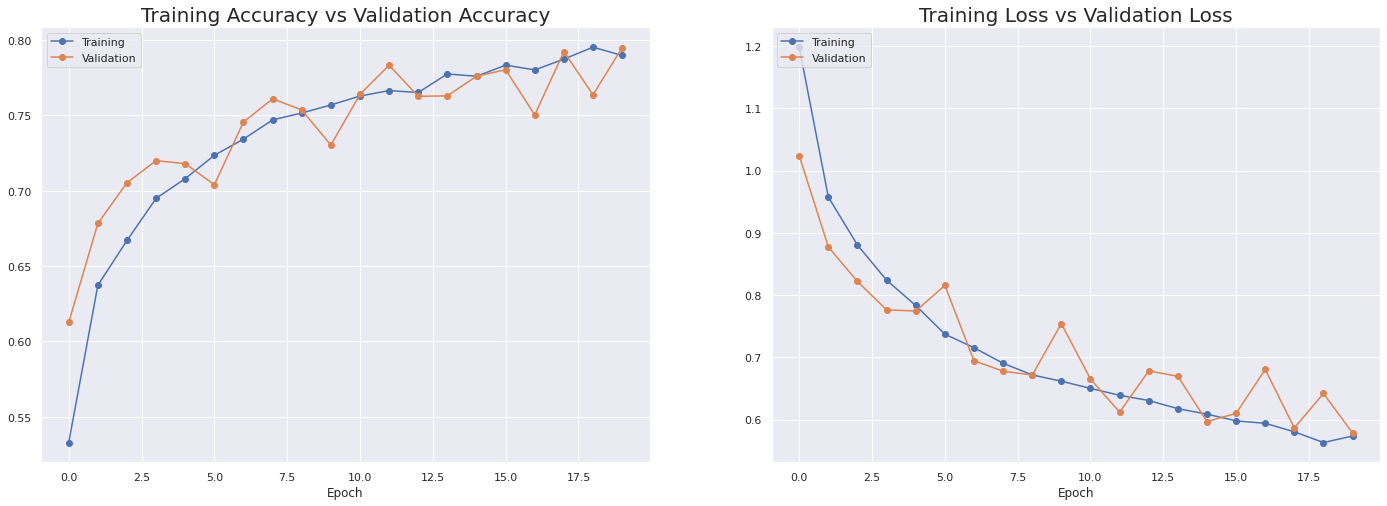

In [107]:
# Plot accuracy and loss for training and validation sets
plot_loss(convnet_log, 20)

* Even though we have only two convolutional layers, we achieve a decent validation accuracy of 0.79 after 20 epochs. 

* The learning curves above indicate that the base model has little overfitting. This is because when a model overfits, the training loss continues to decrease while the validation loss remains constant. In the above graphs, this does not appear to occur.

__Model 2: Deep convolutional neural network__

* The second model is a deep convolutional network with six contovlutional layers, three pooling layers, and 725,334 trainable parameters. 

* The architecture of this model is outlined in the following schematic diagram. Layer labels can be deduced from the tensor dimensions in the diagram and their corresponding layers in the `Sequential()` code below:

<img src="https://i.imgur.com/J3acAr8.png" />

* In addition to being deeper than the base model, this model will also have some hyperparameters tuned using the `keras_tuner` library [Link](https://keras.io/keras_tuner/). This library will take our deep convolutional model and find the optimal set of hyperparameters over a pre-defined search space. 

* We will keep the search space simple by focusing on tuning parameters for three layers in the above architecture:

    1. The number of output filters in the first convolutional layer.
    2. The number of units in the first fully connect layer. 
    3. The learning rate of our optimizer. 

In [ ]:
# Define our deep cnn model and hyperparameter search space for keras_tuner
def deep_cnn_tuning(hp):
    '''
    Constructs and returns our deep cnn model with hyperparameter search space.
    This function is passed to the keras_tuner hyperband algorithm.
    '''
    # Define search space for hyperparameters
    hp_dense_units = hp.Int('units', min_value=32, max_value=128, step=32)
    hp_conv_filters = hp.Int('filters', min_value=8, max_value=32, step=8)
    hp_lr = hp.Choice('learning_rate', values=[1e-3, 1e-4])

    # Model 2: convolutional neural network
    deep_model = Sequential([
        # Input layer: data augmentation and standardization
        augmentation_layer,
        standardization_layer,

        # Convolutional layers
        layers.Conv2D(filters=hp_conv_filters, 
                      kernel_size=(4,4), 
                      strides=(1,1),
                      padding='same', 
                      activation='relu'),
        layers.Conv2D(16, (8,8), (1,1), padding='same', activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(16, (4,4), (1,1), padding='same', activation='relu'),
        layers.Conv2D(32, (8,8), (1,1), padding='same', activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (8,8), (4,4), padding='same', activation='relu'),
        layers.Conv2D(128, (8,8), (4,4), padding='same', activation='relu'),
        layers.MaxPooling2D(3,3),

        # Fully connected layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(units=hp_dense_units, activation='relu'),
        layers.Dense(32, activation='relu'),

        # Output layer
        layers.Dense(len(class_labels), activation='softmax')
    ])

    # Compile the base model
    opt = keras.optimizers.Adam(learning_rate=hp_lr)
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    deep_model.compile(optimizer=opt,
                       loss=loss,
                       metrics=['accuracy'])
    return deep_model


# Instantiate the hyperband tuner
tuner = kt.Hyperband(hypermodel=deep_cnn_tuning, 
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=2,
                     directory=dataset.PATH + 'hp_logs',
                     project_name='model_2_deep_cnn')

# Callback to stop training after reaching certain validation loss
hault = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Run hyperparameter search
tuner.search(train, 
             epochs=20, 
             validation_data=test, 
             callbacks=[hault])

* With the hyperparameter search complete, I will display the best hyperparameters found and use them during training.

In [83]:
# Get optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
hp_filters = best_hps.get('filters')
hp_units = best_hps.get('units')
hp_lr = best_hps.get('learning_rate')

# Print hyperparameter search results and model summary
display(Markdown(f"__Hyperparameter tuning results__"))
display(Markdown(f"* First convolutional layer filters = {hp_filters}"))
display(Markdown(f"* First dense layer units = {hp_units}"))
display(Markdown(f"* Optimizer learning rate = {hp_lr}"))

__Hyperparameter tuning results__

* First convolutional layer filters = 16

* First dense layer units = 96

* Optimizer learning rate = 0.001

In [84]:
# Model 2: deep convolutional neural network
deep_model = Sequential([
    # Input layer: data augmentation and standardization
    augmentation_layer,
    standardization_layer,

    # Convolutional layers
    layers.Conv2D(filters=hp_filters, 
                  kernel_size=(4,4), 
                  strides=(1,1), 
                  padding='same', 
                  activation='relu'),
    layers.Conv2D(16, (8,8), (1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(16, (4,4), (1,1), padding='same', activation='relu'),
    layers.Conv2D(32, (8,8), (1,1), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (8,8), (4,4), padding='same', activation='relu'),
    layers.Conv2D(128, (8,8), (4,4), padding='same', activation='relu'),
    layers.MaxPooling2D(3,3),

    # Fully connected layers
    layers.GlobalAveragePooling2D(),
    layers.Dense(units=hp_units, activation='relu'),
    layers.Dense(32, activation='relu'),

    # Output layer
    layers.Dense(len(class_labels), activation='softmax')
])

# Compile the base model
opt = keras.optimizers.Adam(learning_rate=hp_lr)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
deep_model.compile(optimizer=opt,
                   loss=loss,
                   metrics=['accuracy'])

# Summarize model trainable parameters
deep_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 150, 150, 16)      784       
                                                                 
 conv2d_7 (Conv2D)           (None, 150, 150, 16)      16400     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 75, 75, 16)        4112      
                                                      

In [85]:
%%time
# Train the deep model
deep_model_log = deep_model.fit(
    train,
    validation_data=test,
    epochs=20,
    use_multiprocessing=True
)

Epoch 1/20
220/220 [==============================] - 22s 95ms/step - loss: 1.4142 - accuracy: 0.4008 - val_loss: 1.0097 - val_accuracy: 0.5820
Epoch 2/20
220/220 [==============================] - 21s 95ms/step - loss: 0.9741 - accuracy: 0.6176 - val_loss: 0.8539 - val_accuracy: 0.6723
Epoch 3/20
220/220 [==============================] - 21s 94ms/step - loss: 0.8597 - accuracy: 0.6712 - val_loss: 0.8437 - val_accuracy: 0.6630
Epoch 4/20
220/220 [==============================] - 21s 94ms/step - loss: 0.7760 - accuracy: 0.7092 - val_loss: 0.7687 - val_accuracy: 0.7083
Epoch 5/20
220/220 [==============================] - 21s 94ms/step - loss: 0.7298 - accuracy: 0.7290 - val_loss: 0.7069 - val_accuracy: 0.7447
Epoch 6/20
220/220 [==============================] - 21s 94ms/step - loss: 0.6787 - accuracy: 0.7490 - val_loss: 0.6398 - val_accuracy: 0.7673
Epoch 7/20
220/220 [==============================] - 21s 94ms/step - loss: 0.6282 - accuracy: 0.7751 - val_loss: 0.5654 - val_accuracy:

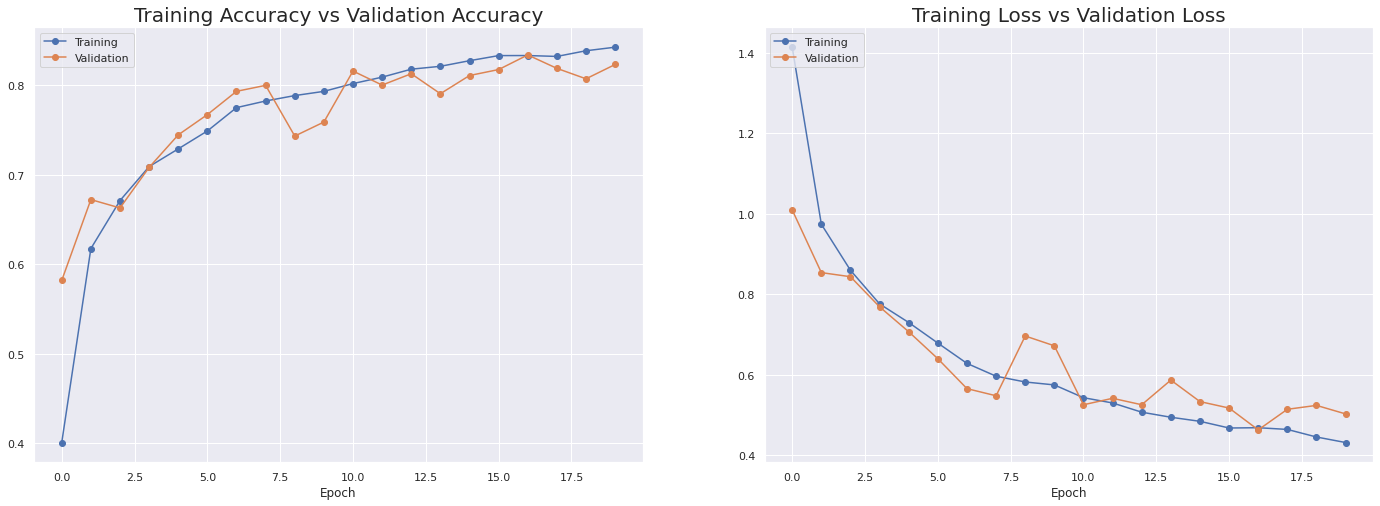

In [86]:
# Plot accuracy and loss for training and validation sets
plot_loss(deep_model_log, 20)

* The above graphs indicate that the deep convolutional neural network model achieves a slightly higher validation accuracy of 0.82 over the same amount of training epochs as the base model while also maintaining a low degree of overfitting.

__Model 3: Google inception v3 transfer learning__

* The third model is a transfer learning model specialized for image classification tasks. It was trained using millions of labeled images, and it has over 20 million pre-trained parameters. 

* The architecture of this pre-trained model is outlined in the high-level schematic diagram below which is from the inception V3 docs found here: [docs](https://cloud.google.com/tpu/docs/inception-v3-advanced).

<img src="https://i.imgur.com/F8X68Ik.png">

In [132]:
# Instantiate the inception v3 architecture
# Ref: https://keras.io/guides/transfer_learning/
inceptionV3 = InceptionV3(weights='imagenet', 
                          input_shape=(150, 150, 3), 
                          include_top=False, 
                          classes=6)

# Freeze the training parameters of the transfered model
inceptionV3.trainable = False

# Model 3: Incepton Add dropout Layer
inceptionV3_model = Sequential([
    # Input layer: data augmentation and standardization
    augmentation_layer,
    standardization_layer,

    # Transfer learning layers
    inceptionV3,

    # Fully connected layers with dropout
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(rate=0.2),

    # Output layer
    layers.Dense(len(class_labels), activation='softmax')
])

inceptionV3_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

inceptionV3_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_19 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                      

In [133]:
# Train the transfer learning model
inceptionV3 = inceptionV3_model.fit(
    train, 
    validation_data=test,
    epochs=20, 
    use_multiprocessing=True
)

Epoch 1/20
220/220 [==============================] - 22s 82ms/step - loss: 0.5956 - accuracy: 0.8055 - val_loss: 0.3185 - val_accuracy: 0.8917
Epoch 2/20
220/220 [==============================] - 16s 74ms/step - loss: 0.4054 - accuracy: 0.8526 - val_loss: 0.3077 - val_accuracy: 0.8893
Epoch 3/20
220/220 [==============================] - 16s 75ms/step - loss: 0.3680 - accuracy: 0.8650 - val_loss: 0.3876 - val_accuracy: 0.8487
Epoch 4/20
220/220 [==============================] - 16s 75ms/step - loss: 0.3582 - accuracy: 0.8698 - val_loss: 0.2945 - val_accuracy: 0.8943
Epoch 5/20
220/220 [==============================] - 16s 74ms/step - loss: 0.3391 - accuracy: 0.8717 - val_loss: 0.3473 - val_accuracy: 0.8800
Epoch 6/20
220/220 [==============================] - 16s 74ms/step - loss: 0.3294 - accuracy: 0.8778 - val_loss: 0.2872 - val_accuracy: 0.8880
Epoch 7/20
220/220 [==============================] - 16s 74ms/step - loss: 0.3185 - accuracy: 0.8792 - val_loss: 0.3132 - val_accuracy:

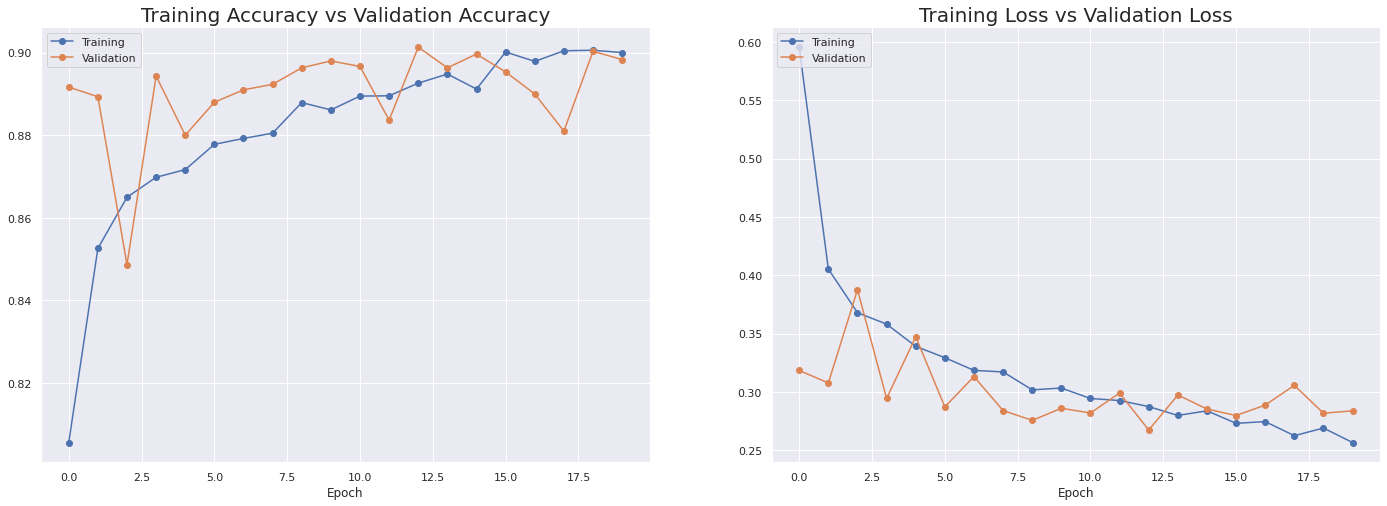

In [134]:
plot_loss(inceptionV3, 20)

* The validation accuracy from this model is 0.90. As expected, this is larger than the prior two models, and it also has low overfitting.

---

## Results and Analysis:

* First, I will use the models to classify images in directory `../seg_pred/*.jpg`. These are images that the models have not seen before and are not labeled. This allows us to look at some of the predicted labels and check if they are consistent with the image.

__Model 1: Convolutional neural network predictions__

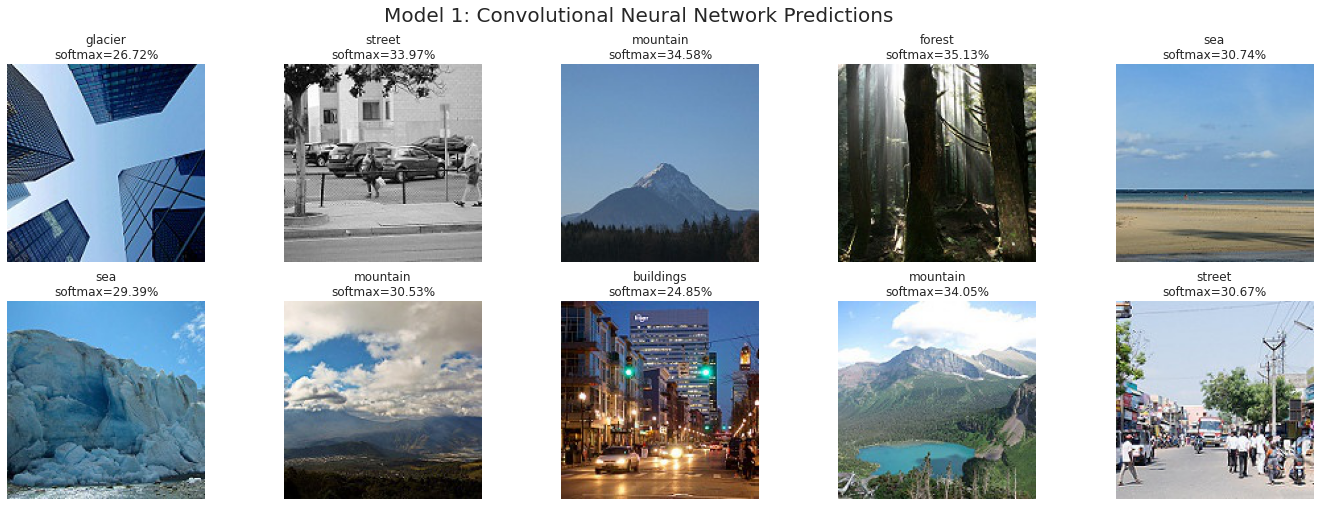

In [114]:
# Plot convolutional model predictions from new unlabeled images
predict_label(path=dataset.pred, 
              model=convnet,
              model_name="Model 1: Convolutional Neural Network", 
              n=10)

* With 0.79 validation accuracy, I expected to find some incorrect predictions. Both predictions on the far left are wrong. The top labeled `glacier` should be `building` and the bottom labeled `sea` should be `glacier`.

__Model 2: Deep convolutional neural network predictions__

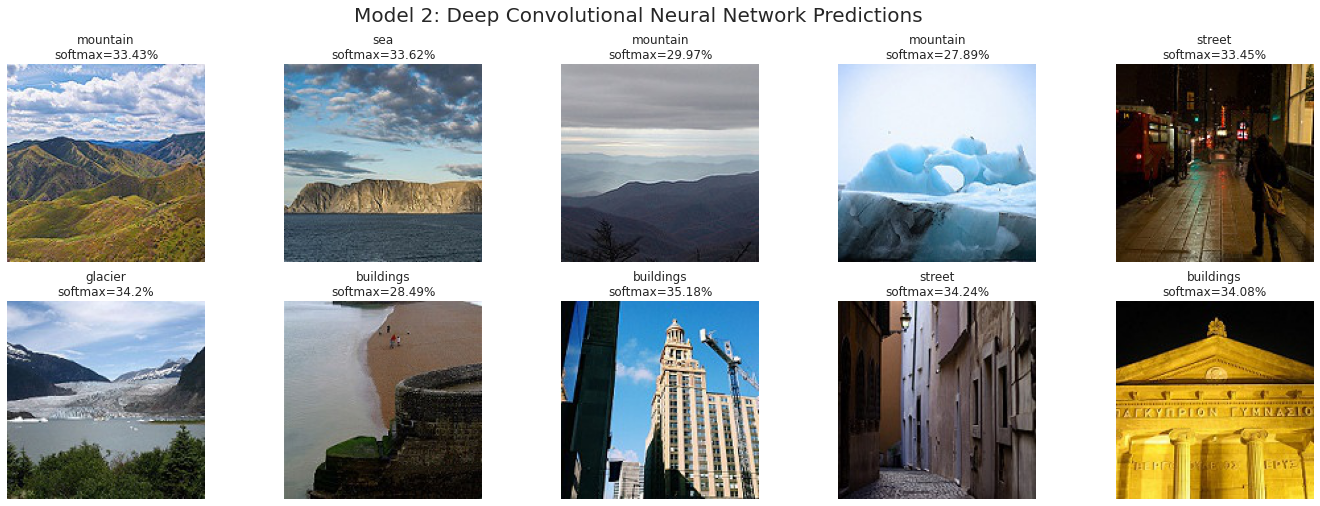

In [123]:
# Plot deep convolutional model predictions from new unlabeled images
predict_label(path=dataset.pred, 
              model=deep_model,
              model_name="Model 2: Deep Convolutional Neural Network", 
              n=10)

* The deep learning model is a slight improvement over the base model with 0.82 validation accuracy. We can see that it had issues with the second to last picture on the top right, which it predicted a `mountain` when it is actually a `glacier`. 

__Model 3: Google inceptionV3 predictions__

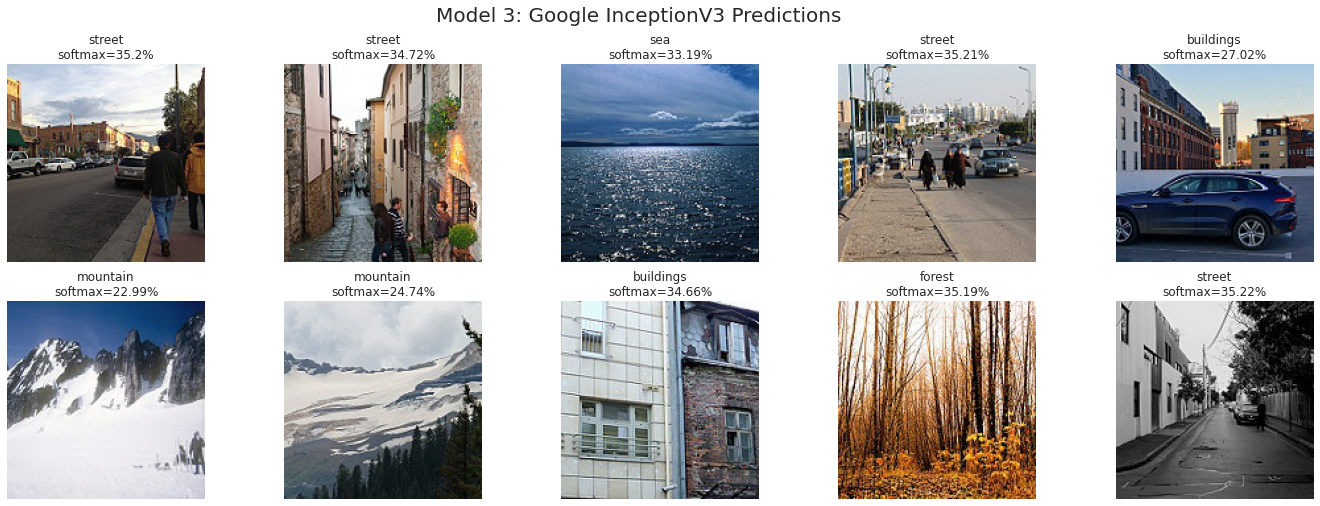

In [131]:
# Plot inceptionV3 predictions from new unlabeled images
predict_label(path=dataset.pred, 
              model=inceptionV3_model,
              model_name="Model 3: Google InceptionV3", 
              n=10)

* Both images at the bottom left are labeled as `mountain`, but the softmax probabilities are low relative to the other predictions. This means the model is a bit indecisive when classifying these images, perhaps because both images have features in common with `glacier`.

__Confusion matrices__

* In this section, I will have each model predict image labels using the test data, and then I will compare these predictions to the true image labels in order to see how many false positives, false negatives, true negatives, and true positives there are. These results will be visualized in confusion matrices.

47/47 - 1s - 552ms/epoch - 12ms/step
47/47 - 1s - 1s/epoch - 25ms/step
47/47 - 3s - 3s/epoch - 54ms/step


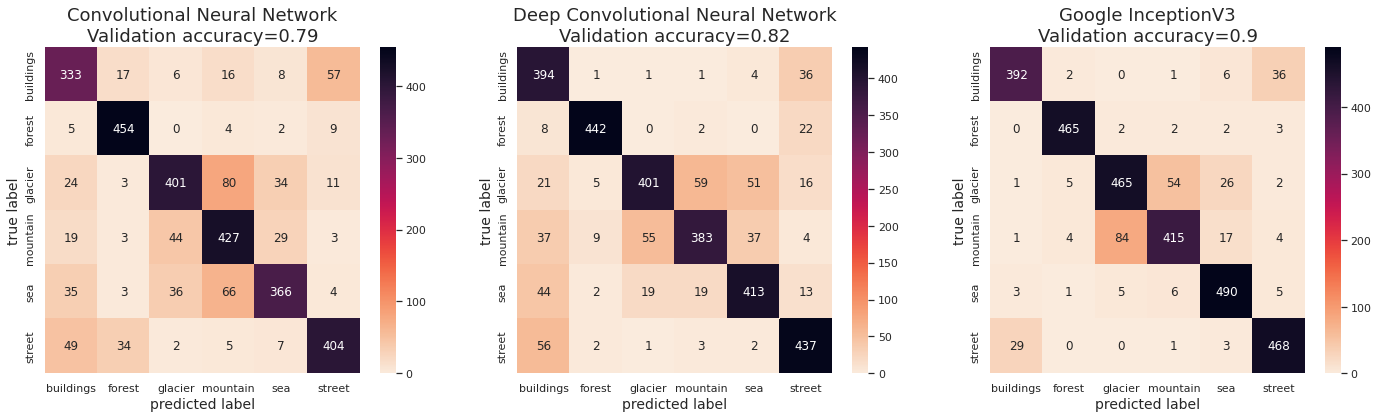

In [138]:
# Compute confusion matrices for each model
cms, preds = [], []
models = [convnet, deep_model, inceptionV3_model]
for model in models:
    cm, p = compute_confusion_matrix(model, test, class_labels)
    cms.append(cm)
    preds.append(p)

# Plot confusion matrices
titles = ["Convolutional Neural Network", 
          "Deep Convolutional Neural Network", 
          "Google InceptionV3"]
training_acc = [0.79, 0.82, 0.90]
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,6))
for cm, acc, t, ax in zip(cms, training_acc, titles, axes.flat):
    cm_heatmap = sns.heatmap(cm.numpy(), 
                             annot=True, 
                             fmt='g', 
                             xticklabels=class_labels, 
                             yticklabels=class_labels, 
                             cmap='rocket_r', 
                             ax=ax)
    ax.set_title(label=f"{t}\nValidation accuracy={acc}", 
                 fontdict={'fontsize':18})
    ax.set_ylabel("true label", fontsize=14)
    ax.set_xlabel("predicted label", fontsize=14)

* From left to right we can see that the base convolutional model has the lowest true positive count, the deep convolutional model is a slight improvement, and the transfer learning model has the most true positive predictions.

* It's interesting to see common false negatives and false positives shared by each model. In all three cases, the models struggled with separating `streets` from `buildings`, and `mountains` from `glaciers`.

__Receiver operating characteristic (ROC) curves__

* ROC curves allow us to compare model performance by plotting true positive predictions versus the rate of false positive predictions at different classification thresholds. Ideally, the true positive rate will be high and the false positive rate will be low, corresponding to a plot with an elbow curve at the upper left. The area under the curve (AUC) simply quantifies this performance; more area corresponds to more true positives and fewer false positives.

47/47 - 1s - 523ms/epoch - 11ms/step
47/47 - 1s - 1s/epoch - 24ms/step
47/47 - 3s - 3s/epoch - 53ms/step


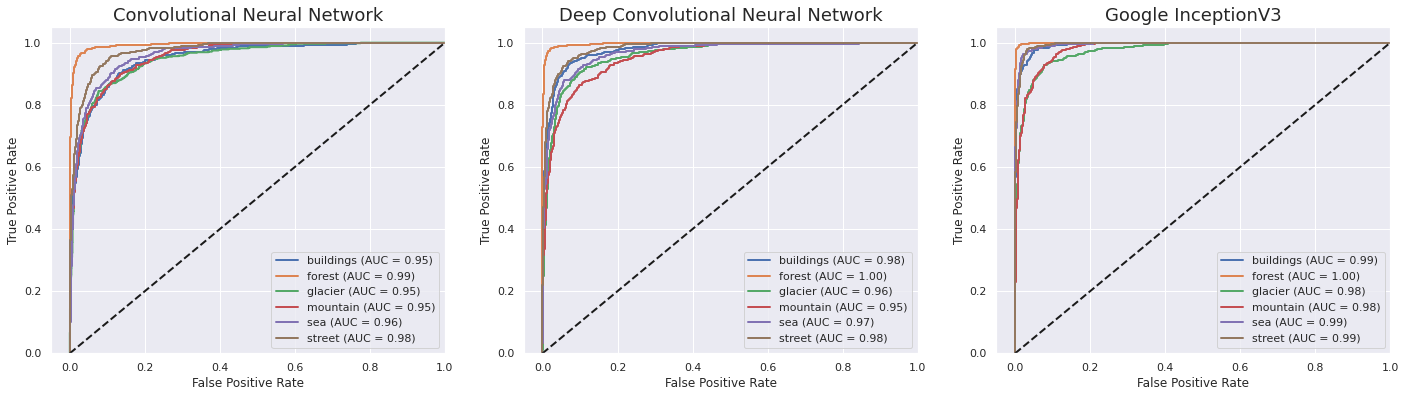

In [136]:
# Compute AUC and plot ROC curves from the predictions by each model
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,6))
for m, t, ax in zip(models, titles, axes.flat):
    plot_multiclass_ROC(y_pred=m.predict(test, verbose=2), 
                        y_true=p[1], 
                        model=m, 
                        class_labels=class_labels, 
                        plot_label=t, 
                        axis=ax)

* The ROC curves indicate a gradual increase in classification from the base model on the far left, to the transfer learning model on the far right. This is consistent with what we find in our confusion matrices. 

* Each model has the highest AUC for `forest` predictions. The `building` and `sea` ROC curves for the deep learning model appear to be clear improvements over the same predictions in the base convolutional neural network model. 

* All three models have a higher false positive rate when classifying `mountains` and `glaciers`.

__Classification Performance Metrics__

* In this last section, I will compare model performance by computing several classification performance metrics. 

In [137]:
# Print classification reports for predictions made by each model
for p, t in zip(preds, titles):
    display(Markdown(f"### {t} classification report"))
    print(classification_report(y_true=p[1], y_pred=p[0]))

### Convolutional Neural Network classification report

              precision    recall  f1-score   support

   buildings       0.72      0.76      0.74       437
      forest       0.88      0.96      0.92       474
     glacier       0.82      0.73      0.77       553
    mountain       0.71      0.81      0.76       525
         sea       0.82      0.72      0.77       510
      street       0.83      0.81      0.82       501

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.79      3000



### Deep Convolutional Neural Network classification report

              precision    recall  f1-score   support

   buildings       0.70      0.90      0.79       437
      forest       0.96      0.93      0.95       474
     glacier       0.84      0.73      0.78       553
    mountain       0.82      0.73      0.77       525
         sea       0.81      0.81      0.81       510
      street       0.83      0.87      0.85       501

    accuracy                           0.82      3000
   macro avg       0.83      0.83      0.82      3000
weighted avg       0.83      0.82      0.82      3000



### Google InceptionV3 classification report

              precision    recall  f1-score   support

   buildings       0.92      0.90      0.91       437
      forest       0.97      0.98      0.98       474
     glacier       0.84      0.84      0.84       553
    mountain       0.87      0.79      0.83       525
         sea       0.90      0.96      0.93       510
      street       0.90      0.93      0.92       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



* The deep convolutional model has a weighted average F1 score of 0.82. This is only a marginal improvement over the base model which has a weighted average F1 score of 0.79. 

* The transfer learning model has a weighted F1 score of 0.90. This is a large improvement in classification performance over both the base model and the deep convolutional model.

* All models had the highest precision, accuracy, and F1 scores for `forest` predictions, and these classification metrics are consistently low for `mountain` or `glacier` predictions.

__Results summary and analysis__

* The confusion matrices indicate that all models excelled at classifying `forest` images but struggled at separating `streets` from `buildings` and `mountain` from `glacier`. 

* ROC curves and F1 scores indicate that classification performance improved from the base model to the transfer learning model. 

* The classification performance metrics support the conclusions made from the confusion matrices and ROC curves, with `forest` predictions having the largest weighted F1 scores, and `mountain` or `glacier` predictions having the lowest weighted F1 scores. 

## Conclusions and Discussion

__Summary of results__

* Overall classification performance improved from the base model to the Google inceptionV3 model. The validation accuracy of these models ranged from 0.79 to 0.90 with low overfitting.


* All models excelled at classifying `forest`, which had the highest rate of true positive and lowest rate of false positive predictions. 

* All models had varying degrees of difficulty classifying `mountains` from `glaciers` and `streets` from `buildings`. These predictions accumulated the most false positives and false negatives, presumably due to many similar features shared between each image. 


__Discussion and improvements__

The results indicate that every model can be improved if we use methods to better separate `mountain` images from `glacier` images, and `street` images from `building` images. This could be a difficult task because these images can be a bit ambiguous. For example, glaciers are often shaped like mountains, and buildings are often surrounded by streets. One improvement, albeit tedious, could involve manually screening the training images for these ambiguous cases, and then remove them. Another improvemet could involve using the RGB channels to delineate between some ambiguous classes. For example, `glacier` images are more likely to have a greater density of blue channels than `mountains`, since glaciers are often rocky and surrounded by ice.

Although deeper layers marginally improved classification performance from the base model, this was at the expense of runtime complexity because we increased the amount of trainable parameters by over double that of the base model. This balance between classification accuracy and runtime complexity made me wonder about possible alternatives wherein we can increase the validation accuracy without necessarily increasing the number of trainable parameters. For example, it would be interesting to experiment with hybrid models that use the ensembling techniques we covered earlier the semester. One example could be treating the base CNN model as a weak learner, and then boosting it with AdaBoost or XGBoost. Another example could be creating multiple convolutional pipelines running in paralell, and then either merging or ensembling the resulting feature maps at different layers and depths. 